# Px Score Validation OS - lgbm_px
```{contents}
```

## Load modules and watermark

In [2]:
from bokeh.models import (Slider, TabPanel, Tabs, Legend, ColumnDataSource, LegendItem,
                          CDSView, GroupFilter, CategoricalColorMapper, Label, Span,
                          DataTable, HoverTool, TableColumn)
from bokeh.io import curdoc, show, output_notebook, save
from bokeh.plotting import figure
from bokeh.embed import json_item
from bokeh.layouts import column
from bokeh.themes import Theme
import pandas as pd
import json

import numpy as np
import pacmap
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import watermark

# output_notebook()

# Set the theme for the plot
# curdoc().theme = 'light_minimal' # or 'dark_minimal

# watermark
%load_ext watermark
%watermark -v -m -p numpy,bokeh,pandas,pacmap

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.20.0

numpy : 1.26.3
bokeh : 3.3.4
pandas: 2.2.0
pacmap: 0.7.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit



## Load data

In [4]:
import pandas as pd

# It is right in front of you. You just need to open your eyes:
df = pd.read_excel('../data/al_atlas_main_results.xlsx', index_col=0).sort_index()


In [5]:
import numpy as np

df2 = df.sort_values(by='P(Dead)').reset_index().reset_index(names=['Percentile'])

df2['Percentile'] = df2['Percentile'] / len(df2)

## Plots upon plots

### Bokeh

In [6]:

def create_risk_plot(df2, export=False):
    # Create a ColumnDataSource from df: source
    source = ColumnDataSource(df2)

    p1 = figure(
                tools="pan,wheel_zoom,box_zoom,xbox_select,reset", 
                active_drag="xbox_select", width=600, height=600,)
    p1.toolbar.logo = None

    BINARY_THRESHOLD = 0.5

    # Set the x_range and y_range of the plot to (-3, 3) and (-0.05, 1.1) respectively
    # p1.x_range.bounds = (0.1, 0.9)
    # p1.x_range.start = -0 
    # p1.x_range.end = 1
    # p1.y_range.bounds = (-0.05, 1.1)
    # p1.y_range.start = -0.05
    # p1.y_range.end = 1.1

    # Add circle glyphs to the figure p with the selected and non-selected properties
    p1.circle(x='P(Dead)', y='Percentile', source=source, selection_color='#ff7f0e', 
              nonselection_alpha=1.0, color='#1f77b4', size=5, alpha=0.8, hover_color='#ff7f0e',
              hover_alpha=1.0)
    

    # Axis labels and range
    p1.xaxis.axis_label = "AML Epigenomic Risk Probability"
    p1.yaxis.axis_label = "est. probability of event"
    p1.xaxis.axis_label_text_font_size = "10pt"
    p1.yaxis.axis_label_text_font_size = "10pt"
    p1.xaxis.axis_label_text_font_style = "normal"
    p1.yaxis.axis_label_text_font_style = "normal"

    # Add vertical line at the binary threshold
    p1.add_layout(Span(location=BINARY_THRESHOLD, dimension='height', line_color='black'))

    # Text annotations for risk categories
    labels = [
        Label(x=-BINARY_THRESHOLD, y=20, text="Low Risk", text_color='black', text_align='center', y_units='screen'),
        Label(x=BINARY_THRESHOLD + 0.45, y=20, text="High Risk", text_color='black', text_align='center', y_units='screen'),
    ]

    for label in labels:
        p1.add_layout(label)

    # Existing columns
    columns = [
        TableColumn(field="WHO 2022 Diagnosis", title="WHO 2022 Diagnosis"),
        TableColumn(field="Vital Status", title="Vital Status"),
        TableColumn(field="Clinical Trial", title="Clinical Trial"),
        TableColumn(field="FLT3 ITD", title="FLT3 ITD"),
        TableColumn(field="Gene Fusion", title="Gene Fusion")
    ]

    data_table = DataTable(source=source, columns=columns, editable=True, width=600)


    # Define the tooltips for the HoverTool
    tooltips = [
        ("P(Dead)", "@{P(Dead)}"),
        ("Percentile", "@{Percentile}"),
        ("AML Epigenomic Risk", "@{AML Epigenomic Risk}"),
    ]
    hover = HoverTool(tooltips=tooltips)
    p1.add_tools(hover)

    #### ------------------ PaCMAP Plot ------------------ ####

    # Custom color palette
    custom_color_palette = [
        '#1f77b4',  # Vivid blue
        '#ff7f0e',  # Vivid orange 
        '#2ca02c',  # Vivid green
        '#d62728',  # Vivid red
        '#9467bd',  # Vivid purple 
        '#7f7f7f',  # Medium gray
        '#e377c2',  # Pink
        '#e7ba52',  # Light orange
        '#bcbd22',  # Olive
        '#17becf',  # Light blue
        '#393b79',  # Dark blue
        '#8c564b',  # Brown
        '#f7b6d2',  # Light pink
        '#c49c94',  # Light brown
        '#a2769e',  # Soft purple
        '#dbdb8d',  # Pale yellow
        '#9edae5',  # Pale cyan
        '#c5b0d5',  # Pale purple
        '#c7c7c7',  # Light gray
        '#ff9896',  # Light red
        '#637939',  # Dark olive
        '#aec7e8',  # Light blue
        '#ffbb78',  # Light orange
        '#98df8a',  # Light green
        '#7c231e',  # Dark red
        '#3d6a3d',  # Dark green
        '#f96502',  # Deep orange
        '#6d3f7d',  # Deep purple
        '#6b4423',  # Dark brown
        '#d956a6'   # Hot pink
    ]

    # Initial setup
    title = ''
    # x_range = (-45, 45)
    # y_range = (-45, 45)
    datapoint_size = 1
    tooltip_dx_cols = 'WHO 2022 Diagnosis'
    width = 600
    height = 1200

    # Initialize Bokeh Document with theme
    curdoc().theme = Theme(json={
        "attrs": {
            "Axis": {
                "major_label_text_color": 'black',
                "major_label_text_font": 'Arial',
            },
            "Legend": {
                "label_text_color": 'black',
                "label_text_font": 'Arial',
            },
            "Title": {
                "text_color": 'black',
                "text_font": 'Arial',
            },
        }
    })

    tabs = []
    slider = Slider(title="Adjust datapoint size", start=0, end=10, step=1, value=datapoint_size)

    cols = ['WHO 2022 Diagnosis', 'Vital Status', 'AL Epigenomic Phenotype']

    for col in cols:
        factors = [str(val) for val in df2[col].unique() if pd.notnull(val)]
        color_mapper = CategoricalColorMapper(factors=factors, palette=custom_color_palette)

        p = figure(title=title, width=width, height=height,
                    # x_range=x_range, y_range=y_range, 
                tools="pan,wheel_zoom,reset,save,box_select", tooltips=[("Dx", "@{"+tooltip_dx_cols+"}")], 
                x_axis_label='Longitude (PaCMAP 1)', y_axis_label='Latitude (PaCMAP 2)', active_drag="box_select")
        p.toolbar.logo = None
        p.toolbar_location = 'above'
        p.xaxis.axis_label_text_font_size = "10pt"
        p.yaxis.axis_label_text_font_size = "10pt"
        p.xaxis.axis_label_text_font_style = "normal"
        p.yaxis.axis_label_text_font_style = "normal"

        # Create scatter plot for each factor
        for factor in factors:
            view = CDSView(filter=GroupFilter(column_name=col, group=factor))
            p.scatter(x="PaCMAP 1 of 2", y="PaCMAP 2 of 2", source=source, view=view, 
                    color={'field': col, 'transform': color_mapper})

        # Create a list of legend items
        legend_items = [LegendItem(label=factor, renderers=[r]) for factor, r in zip(factors, p.renderers)]

        # Create a legend
        legend = Legend(items=legend_items, location="center")

        # Add the legend to the plot
        p.add_layout(legend, 'below')

        tab = TabPanel(child=p, title=col)
        tabs.append(tab)

    tabs_control = Tabs(tabs=tabs, tabs_location='above')

    layout = column(
                    tabs_control,
                    slider,
                    p1,
                    data_table,
                    )

    return layout

save(create_risk_plot(df2, export=False), filename='bokeh_plot.html', title='AML Epigenomic Risk Plot')

/tmp/ipykernel_12478/2003294337.py:179: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(create_risk_plot(df2, export=False), filename='bokeh_plot.html', title='AML Epigenomic Risk Plot')


'/home/fmarchi/projects/MethylScore/Code/main/bokeh_plot.html'

### Kaplan-Meier Plots

#### Overall study population

In [11]:
df_test = df[df['Train-Test'] == 'Test Sample']

In [7]:
import lifelines

model_name = 'AML Epigenomic Risk'

def draw_kaplan_meier(df, model_name, save_plot=False, figsize=(8, 10), 
                      add_risk_counts=False, save_survival_table=False,
                      trialname=None, show_ci=False):
    """
    Returns a Kaplan-Meier plot with:

        1. Hazard Ratio
        2. P-value
        3. Risk counts
        4. Survival table

    Parameters:
    ----------
    scorename: str
        Name of your model (and a column in df).
    df: object
        A dataframe containing:
            1. Continuous predictions of Cox Regression model under "scorename".
            2. efs/os information in the format of "efs.time" and "efs.evnt".
    save_plot: bool, default=False
        Set to True if you wish to save the plot.It will be saved under "../Figures/ForestPlot/"
    trialname: str
        Name of your clinical trial or dataset.
    scorename: str
        Name of your model.

    Returns:
    --------
        A magnificent double kaplan-meier figure.

    """
    # Import libraries for Kaplan Meier
    from lifelines.plotting import add_at_risk_counts
    from lifelines import KaplanMeierFitter
    from lifelines import CoxPHFitter

    # Set up the matplotlib figure
    sns.set_theme(style='white')
    f, ax = plt.subplots(2, 1, sharex=True, figsize=figsize)

    # Define survival curve categories
    groups = df[model_name]
    ix = (groups == 'High')

    # Fit the Kaplan Meier to each category of groups (kmf1 and kmf2)
    def surv_curves(i, t, e):

        T = df[t]
        E = df[e]
        kmf1 = KaplanMeierFitter()
        kmf1.fit(T[~ix], E[~ix], label='Low-' + model_name + ', n=' +
                 str(len(df[df[model_name].isin(['Low'])])))
        ax = kmf1.plot_survival_function(
            ax=i, show_censors=True, ci_show=show_ci)

        kmf2 = KaplanMeierFitter()
        kmf2.fit(T[ix], E[ix], label='High-' + model_name + ', n=' +
                 str(len(df[df[model_name].isin(['High'])])))
        ax = kmf2.plot_survival_function(
            ax=i, show_censors=True, ci_show=show_ci)

        try:
            # Calculate Hazard Ratio (HZ) and p-value (p)
            X_CPH = df[[model_name + '_int', t, e]]
            cph = CoxPHFitter()
            HZ = cph.fit(X_CPH, t, event_col=e)
            hz = HZ.hazard_ratios_[0]
            p = HZ.summary['p'][0]
            ci_lower = HZ.summary['exp(coef) lower 95%'][0]
            ci_upper = HZ.summary['exp(coef) upper 95%'][0]

            # Annotate HZ, CI, and p
            i.annotate(f'HR: {hz:.4f} (95% CI: {ci_lower:.2f}, {ci_upper:.2f})\n p-value: {p:.4f}',
               xy=(9.75, 0.085), xycoords='data',
               ha='right', va='center', fontsize=11,
               bbox={'boxstyle': 'round', 'facecolor': 'none',
                     'edgecolor': 'lightgray'})
        except:
            pass


        # Add risk counts below the graph
        if add_risk_counts == True:
            add_at_risk_counts(kmf1, kmf2, ax=i)

        # Save Survival Function Table
        if save_survival_table == True:
            surv1 = kmf1.survival_function_.join(kmf1.confidence_interval_)
            surv2 = kmf2.survival_function_.join(kmf2.confidence_interval_)
            surv3 = surv1.join(surv2, how='outer')
            surv3.to_csv('../../Figures/Kaplan_Meiers/KM_' + t + '_SurvivalTable_' +
                         model_name + '_' + trialname + '_' + str(len(df)) + '.csv')

        i.set_ylim(0, 1)
        i.set_ylabel("est. probability of survival $\hat{S}(t)$")

    surv_curves(i=ax[0], t='efs.time', e='efs.evnt')
    surv_curves(i=ax[1], t='os.time', e='os.evnt')

    ax[0].set_title('Event-Free Survival', loc='left',
                    pad=10, fontweight='bold')
    ax[1].set_title('Overall Survival', loc='left', pad=10, fontweight='bold')
    # Define Plot Specs
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.suptitle("Kaplan-Meiers of " + model_name + " in " + trialname + ", n=" + str(len(df)),
                 fontsize='medium', y=0.94,
                 fontweight='bold')
    plt.xlim(0, 10)
    plt.xlabel("time $t$ (years)")

    # Save plot figure
    if save_plot == True:
        plt.savefig('../Figures/Kaplan_Meiers/' + model_name + '_' + trialname + '_' + str(len(df)) + '.png',
                    bbox_inches='tight', dpi=300)

    return (plt.show())

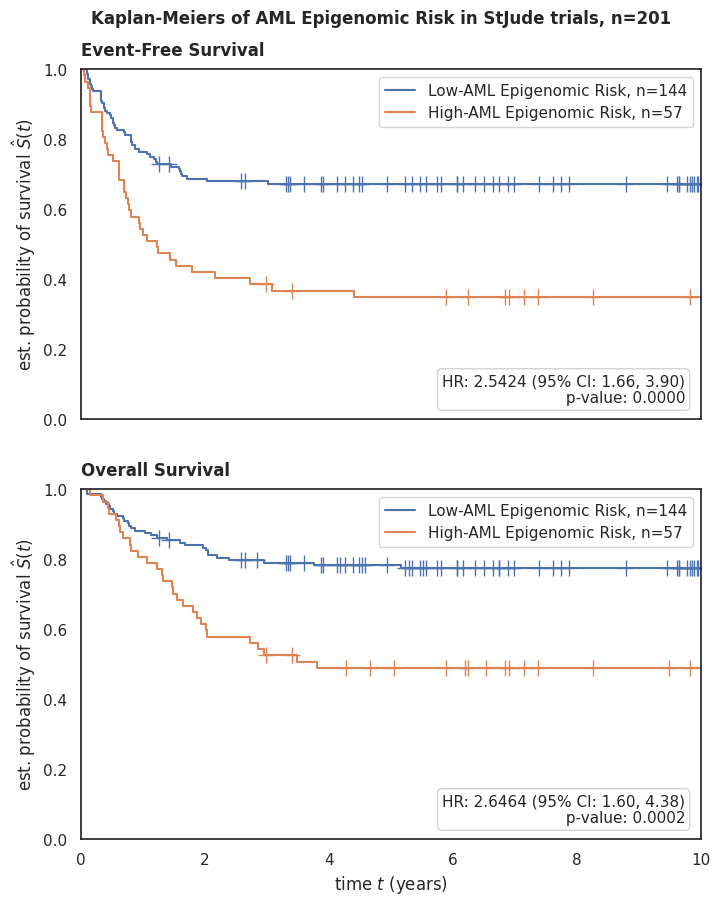

In [14]:
# Import Plotting Functions
# import sys
# sys.path.append('../')
# from source.data_visualization_functions import *

draw_kaplan_meier(model_name=model_name,
                        df=df_test,
                        save_survival_table=False,
                        save_plot=False,
                        show_ci=False,
                        add_risk_counts=False,
                        trialname='StJude trials')

#### Per risk group

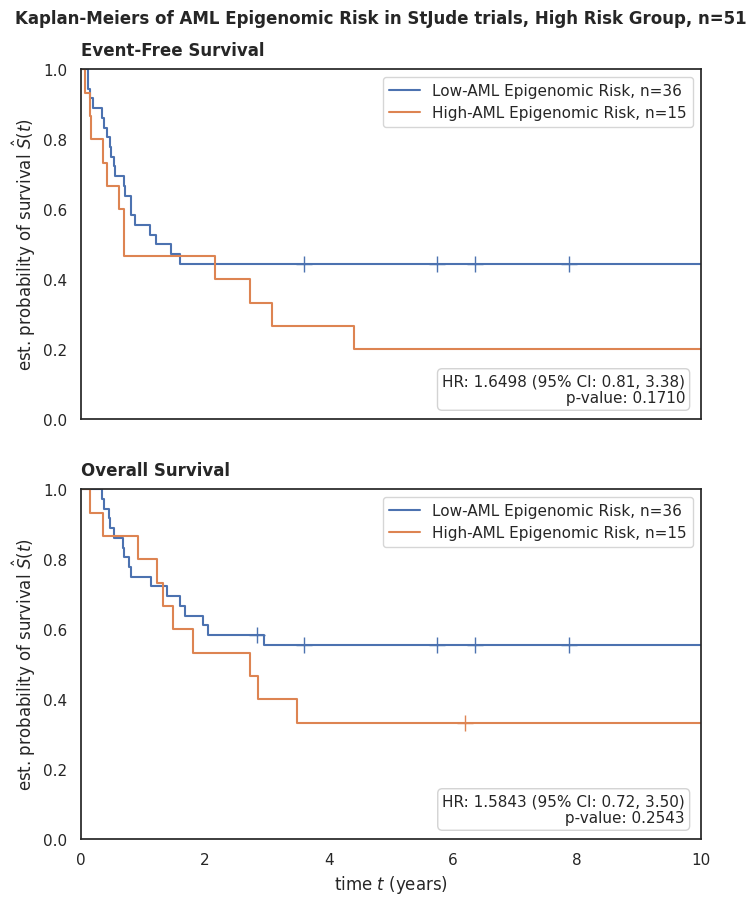

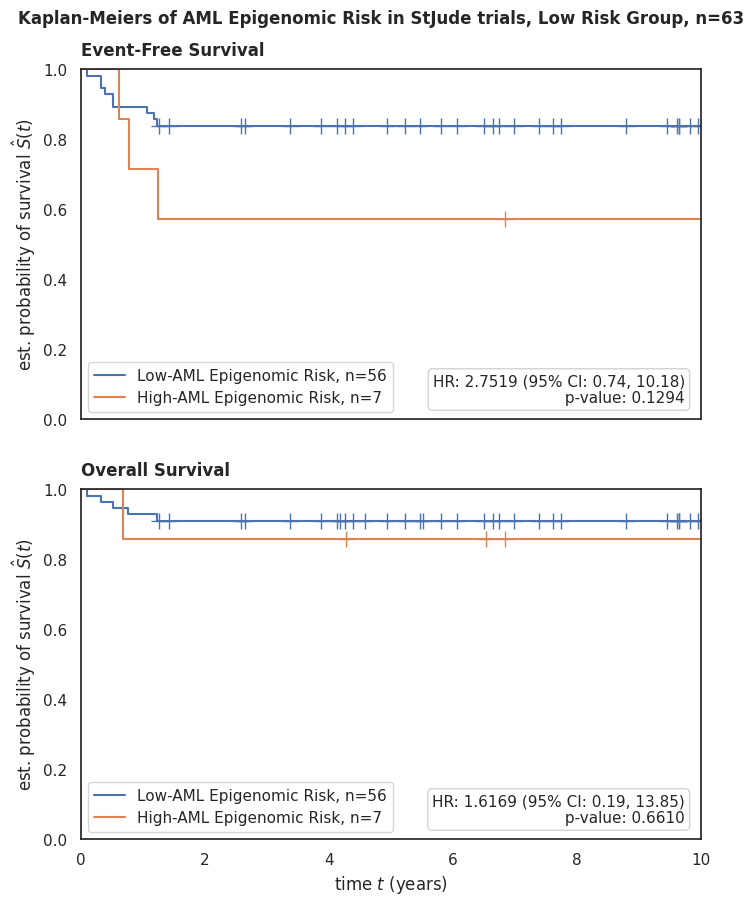

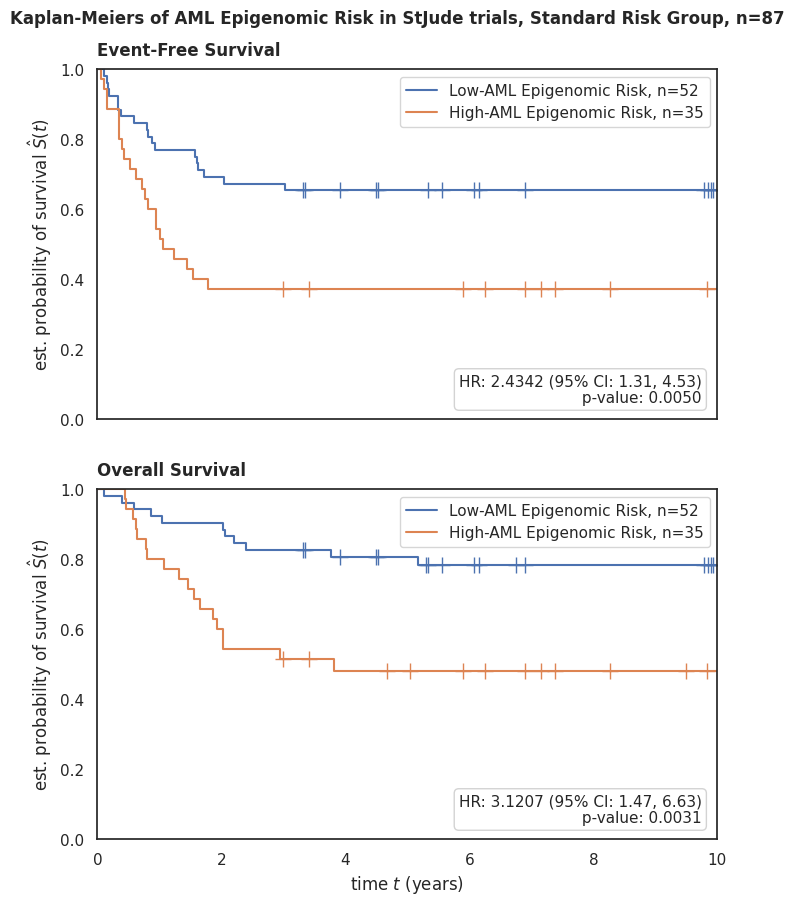

In [17]:
draw_kaplan_meier(model_name=model_name,
                        df=df_test[df_test['Risk Group'] == 'High Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='StJude trials, High Risk Group')

draw_kaplan_meier(model_name=model_name,
                        df=df_test[df_test['Risk Group'] == 'Low Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='StJude trials, Low Risk Group')

draw_kaplan_meier(model_name=model_name,
                        df=df_test[df_test['Risk Group'] == 'Standard Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='StJude trials, Standard Risk Group')

### Forest Plots

#### With MRD 1

In [26]:
df_test['AML_Epigenomic_Risk'] = df_test['AML Epigenomic Risk'] 

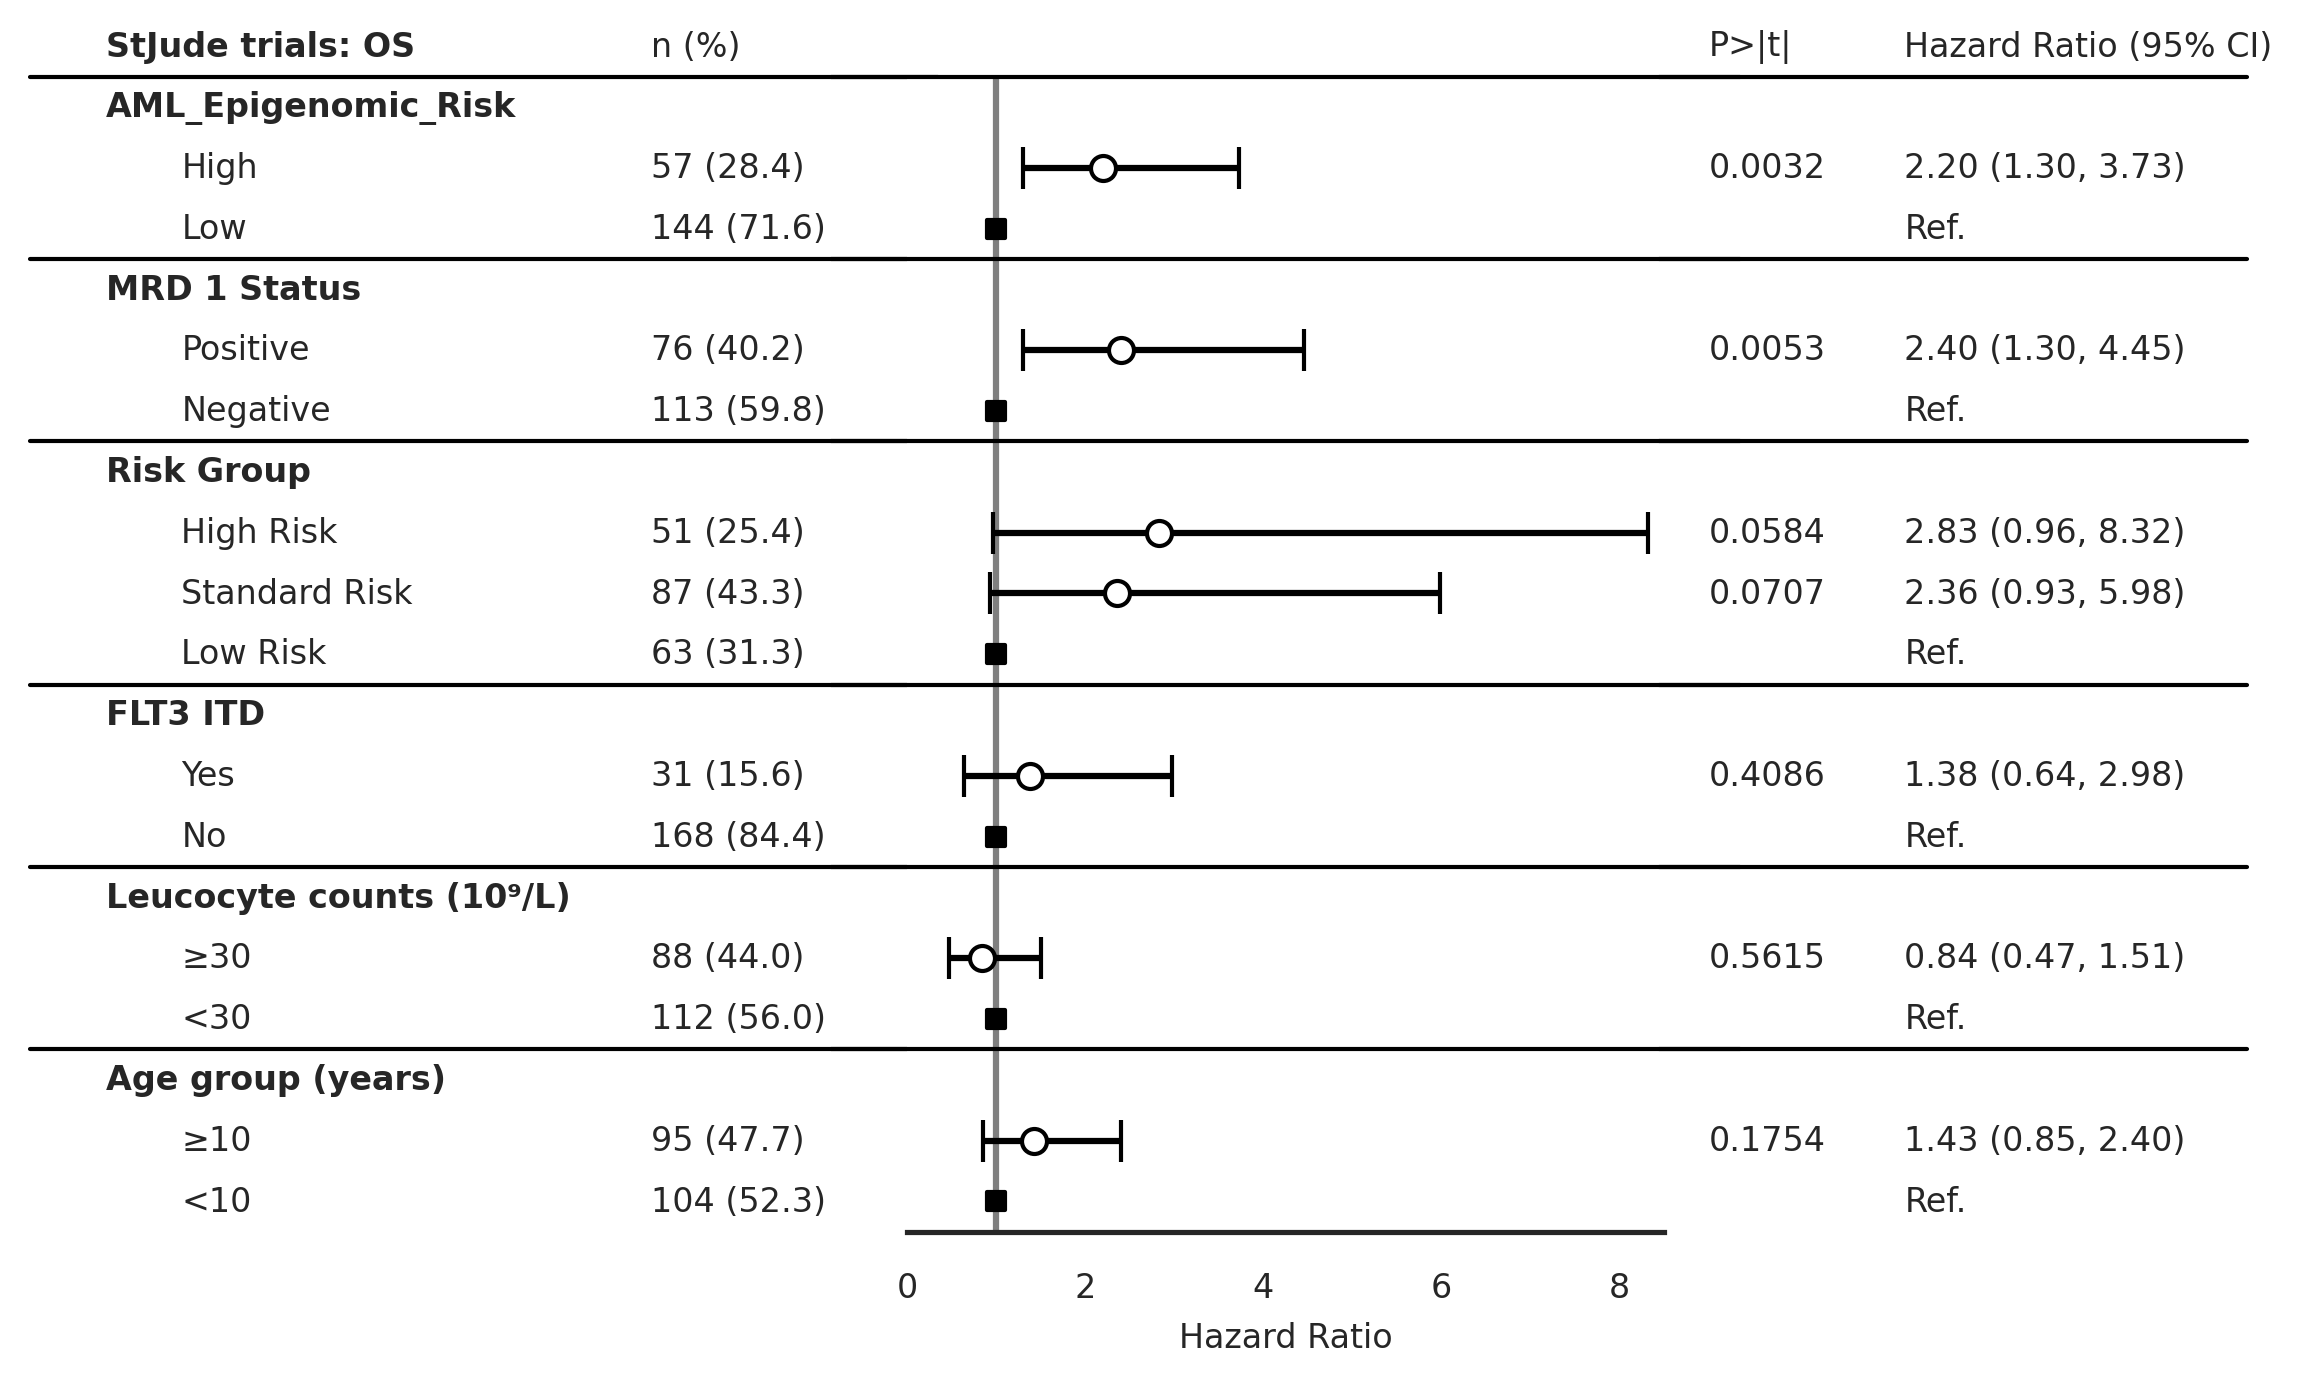

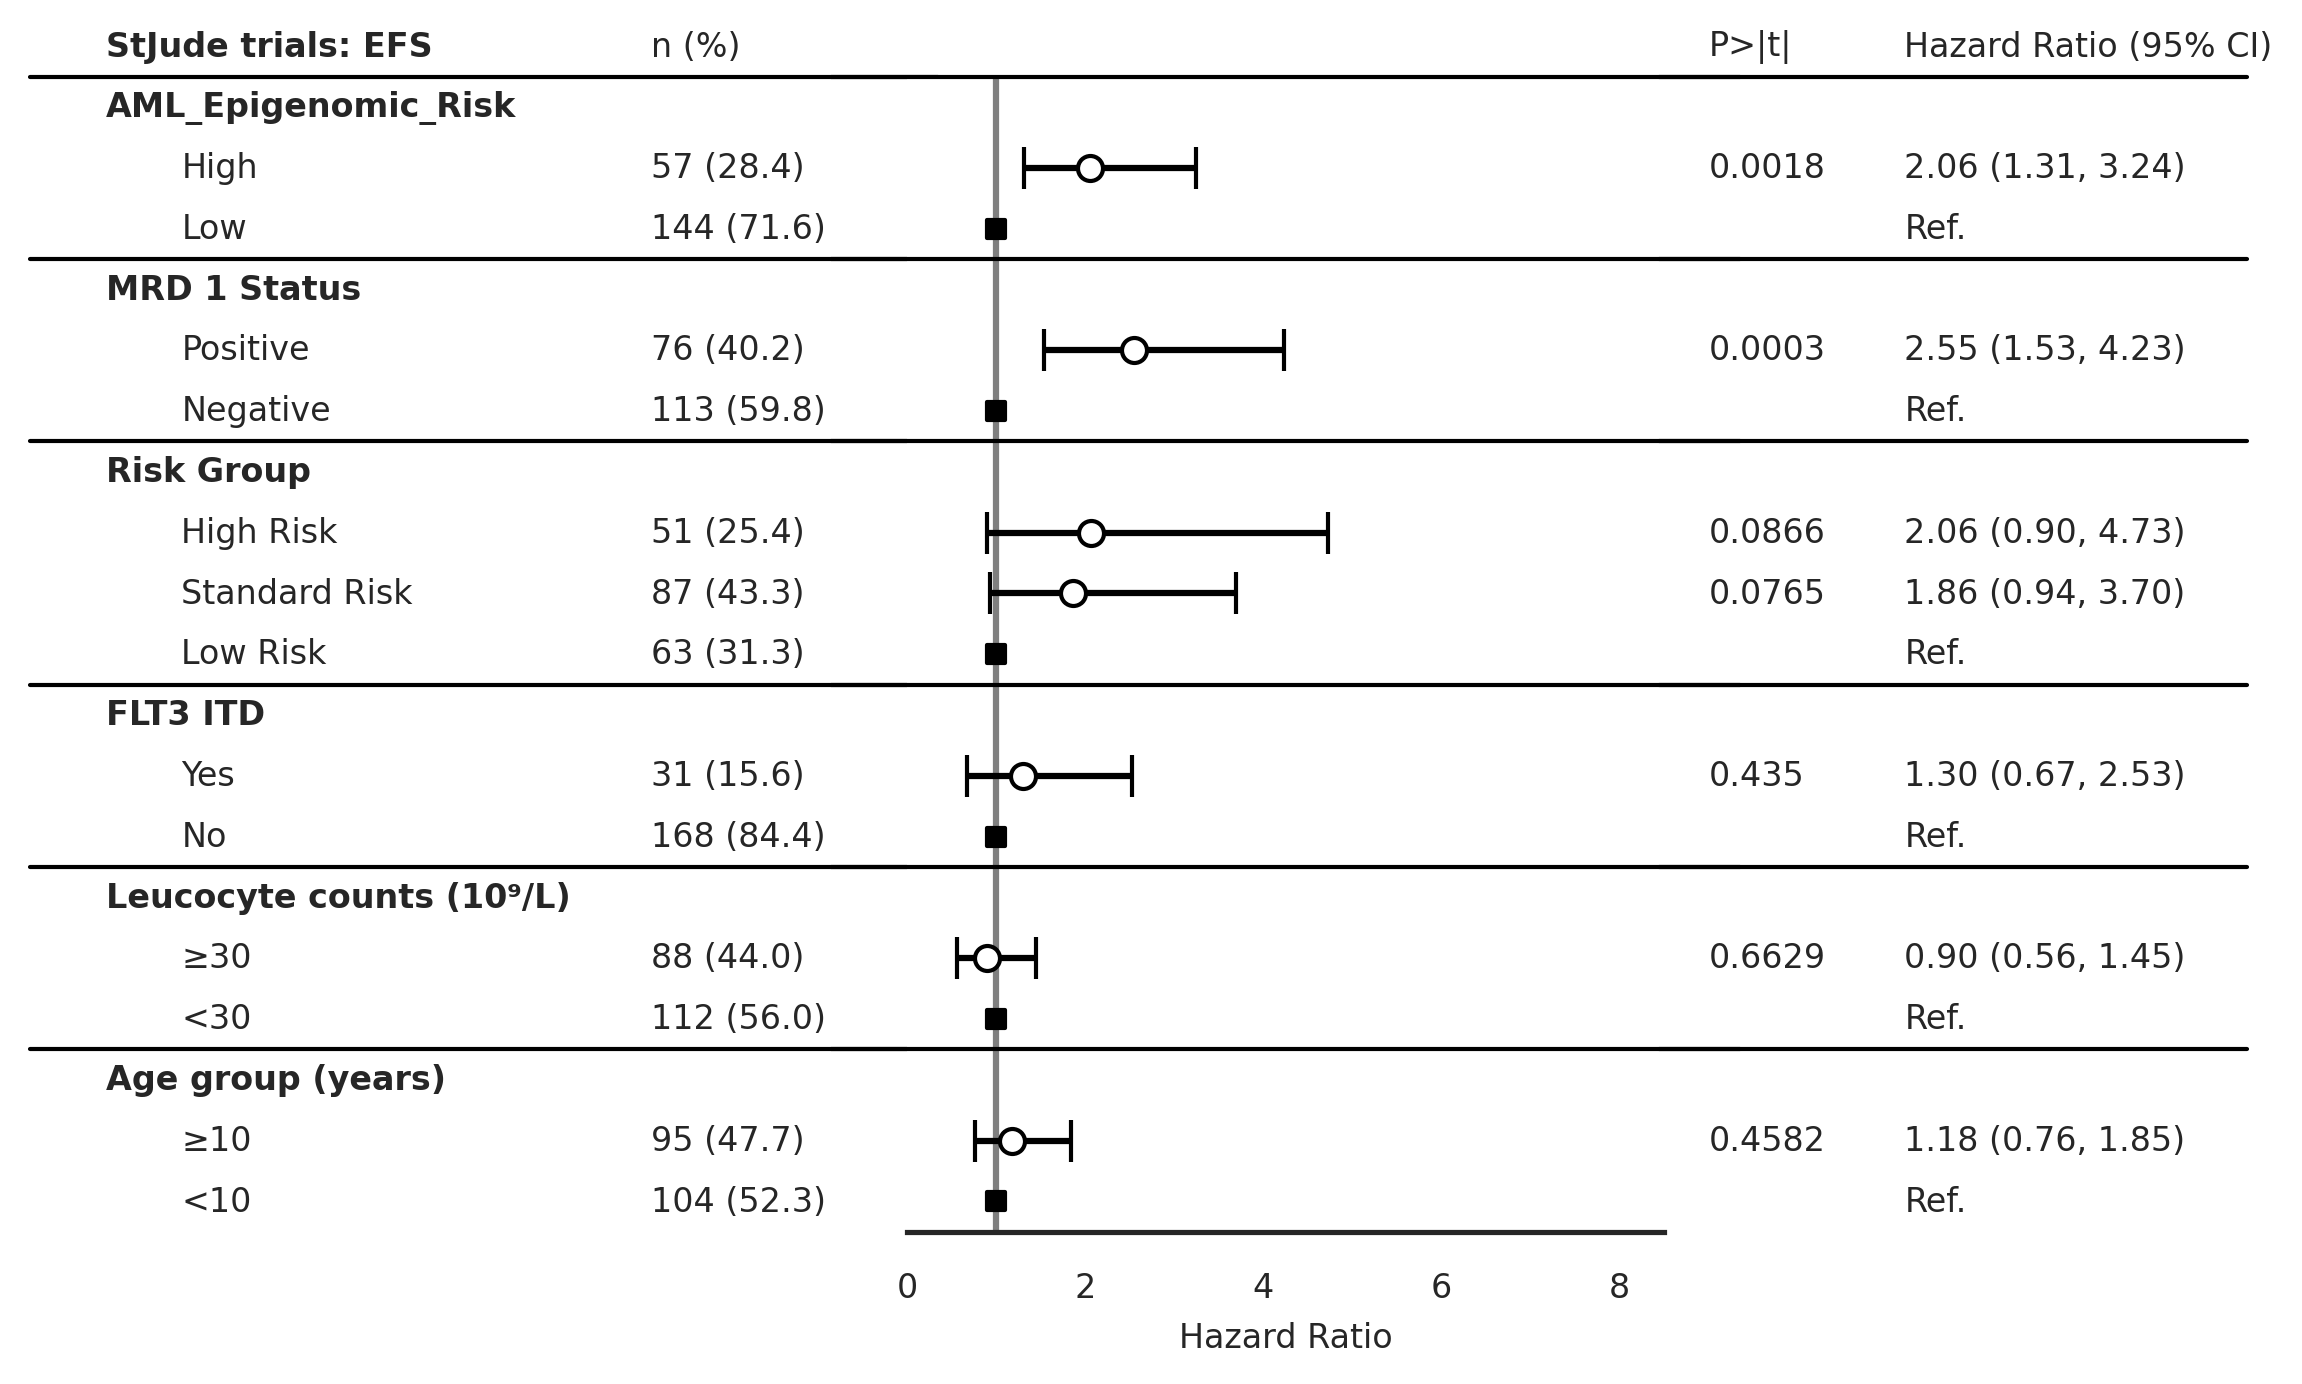

In [28]:
def draw_forest_plot(time, event, df, save_plot=False, trialname=None, scorename=None):
    """
    Generates a custom forest plot.

    Parameters:
    ----------
    time: object
        List of mean coeficients from CoxPH fit.
        Note: this value has to be a pandas series.
    event: object
        Dataframe to add your results to.
    df: object
        A dataframe of variables/features that will be used to calculate the score.
    save_plot: bool, default=False
        Set to True if you wish to save the plot.It will be saved under "../Figures/ForestPlot/"
    trialname: str
        Name of your clinical trial or dataset.
    scorename: str
        Name of your model.

    Returns:
    --------
        A magnificent forest plot.

    """
    import myforestplot as mfp
    from tableone import TableOne
    import statsmodels.formula.api as smf
    import numpy as np
    
    fp = df[[scorename,
             'MRD 1 Status',
             'Risk Group',
             'FLT3 ITD',
             'Leucocyte counts (10⁹/L)',
             'Age group (years)',
             time, event]]

    event2 = event.replace('.', '_')
    time2 = time.replace('.', '_')

    if event[0] == 'o':
        event3 = 'OS'
    else:
        event3 = 'EFS'

    fp2 = fp.rename(columns={event: event2,
                             time: time2,
                             'MRD 1 Status': 'MRD_1_Status',
                             'FLT3 ITD': 'FLT3_ITD',
                             'Risk Group': 'Risk_Group',
                             'Leucocyte counts (10⁹/L)': 'WBC_count',
                             'Age group (years)': 'Age_group'})

    res = smf.phreg(formula=time2 + " ~ C("+scorename+",Treatment(reference='Low')) + C(MRD_1_Status) + C(Risk_Group,Treatment(reference='Low Risk')) + C(FLT3_ITD) + C(WBC_count) + C(Age_group)",
                    data=fp2, status=event2).fit()

    res2 = res.summary(xname=[scorename+'-High',
                              'MRD 1 Status-Positive',
                              'Risk Group-High Risk',
                              'Risk Group-Standard Risk',
                              'FLT3 ITD-Yes',
                              'Leucocyte counts (10⁹/L)-≥30',
                              'Age group (years)-≥10']).tables[1]

    res3 = res2.set_index(res2.index.str.split(pat='-', expand=True))

    mytable = TableOne(data=fp.drop(columns=[event, time]),
                       pval=False, missing=True, overall=True,
                       label_suffix=False, order={scorename: ['High'],
                                                  'MRD 1 Status': ['Positive'],
                                                  'Risk Group': ['High Risk', 'Standard Risk'],
                                                  'FLT3 ITD': ['Yes'],
                                                  'Leucocyte counts (10⁹/L)': ['≥30'],
                                                  'Age group (years)': ['≥10']}).tableone

    mytable2 = mytable.join(res3)

    mytable2["risk_pretty"] = mfp.add_pretty_risk_column(mytable2,
                                                         risk="HR",
                                                         lower='[0.025',
                                                         upper='0.975]',
                                                         fml=".2f"
                                                         )
    mytable3 = mytable2.reset_index(names=['category', 'item']).rename(columns={'HR': 'risk',
                                                                                '[0.025': 0,
                                                                                '0.975]': 1}).iloc[1:, :]

    mytable3['P>|t|'] = round(mytable3['P>|t|'], 4).replace(
        {np.nan: '', 0: '<0.0001'})

    plt.rcParams["font.size"] = 8
    fp = mfp.ForestPlot(df=mytable3,
                        ratio=[3, 3, 2],
                        fig_ax_index=[2],
                        dpi=300,
                        figsize=(9, 5),
                        vertical_align=True)
    fp.errorbar(index=2, errorbar_kwds=None)
    fp.axd[2].set_xlim([1, 8.5])
    fp.axd[2].set_xticks([0, 2, 4, 6, 8])
    fp.axd[2].set_xticklabels(labels=[0, 2, 4, 6, 8], fontdict={'fontsize': 8})
    fp.axd[2].set_xlabel("Hazard Ratio", fontsize=8)
    fp.axd[2].axvline(x=1, ymin=0, ymax=1.0, color="black", alpha=0.5)

    fp.axd[1].set_xlim([0.50, 1])
    fp.embed_cate_strings(1, "category", 0.5, header=trialname + " " + event3,
                          text_kwds=dict(fontweight="bold"),
                          header_kwds=dict(fontweight="bold"),
                          )
    fp.embed_strings(1, "item", 0.55, header="", replace={"age": ""})
    fp.embed_strings(1, "Overall", 0.86, header="n (%)")
    fp.embed_strings(3, "P>|t|", 0, header="P>|t|")
    fp.embed_strings(3, "risk_pretty", 0.4, header="Hazard Ratio (95% CI)")
    fp.horizontal_variable_separators()
    fp.draw_outer_marker(log_scale=False, scale=0.008, index=2)

    # Save plot figure
    if save_plot == True:
        plt.savefig('../Figures/Forest_Plots/' + scorename + '_' + trialname + '_' + str(len(df)) + '_' + event3 + '.png',
                    bbox_inches='tight', dpi=300)

    return (plt.show())


draw_forest_plot(time='os.time',
                    event='os.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename='AML_Epigenomic_Risk',
                    save_plot=False)

draw_forest_plot(time='efs.time',
                    event='efs.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename='AML_Epigenomic_Risk',
                    save_plot=False)

#### Without MRD 1

In [30]:
# draw_forest_plot_noMRD(time='os.time',
#                     event='os.evnt',
#                     df=df_test,
#                     trialname='StJude trials:',
#                     scorename='AML_Epigenomic_Risk',
#                     save_plot=False)

# draw_forest_plot_noMRD(time='efs.time',
#                     event='efs.evnt',
#                     df=df_test,
#                     trialname='StJude trials:',
#                     scorename='AML_Epigenomic_Risk',
#                     save_plot=False)

### ROC AUC

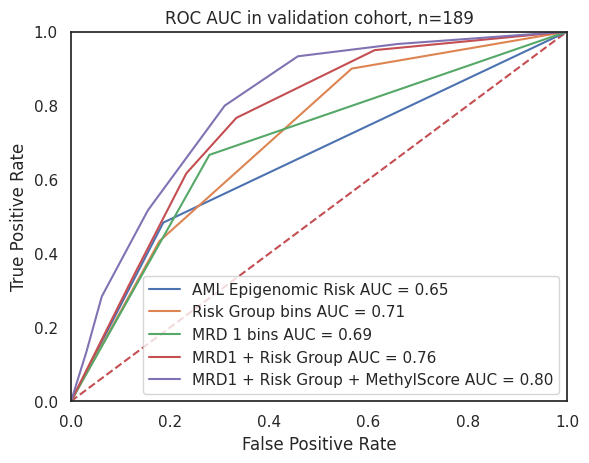

In [34]:
# Your current preprocessing
df_test['Risk Group bins'] = df_test['Risk Group'].replace({'Low Risk':0, 'Standard Risk':0.5, 'High Risk':1})
df_test['MRD 1 bins'] = df_test['MRD 1 Status'].replace({'Negative':0, 'Positive':1})
df_test2 = df_test[['os.evnt', model_name + '_int', 'Risk Group bins', 'MRD 1 bins']].dropna()

# rename column `MethylScoreAML_Px_cat_bin` to `MethylScoreAML Px`
df_test2 = df_test2.rename(columns={model_name + '_int':model_name})

# Add new columns based on standardized values
df_test2['MRD1 + Risk Group'] = df_test['MRD 1 bins'] + df_test['Risk Group bins']
df_test2['MRD1 + Risk Group + MethylScore'] = df_test['MRD 1 bins'] + df_test['Risk Group bins'] + df_test[model_name + '_int']


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def plot_roc_auc(df, score_columns, outcome_column, trial_name='validation cohort'):
    """
    Plots the ROC AUC curves for multiple models given a dataframe and multiple score columns.
    
    Parameters:
    - df (pd.DataFrame): Dataframe containing the score and outcome columns.
    - score_columns (list of str): List of names of columns that contain the scores.
    - outcome_column (str): The name of the column that contains the true outcomes.
    
    Returns:
    None
    """
    
    plt.figure()
    plt.title('ROC AUC in ' + trial_name + ', n={}'.format(len(df)))
    
    # plot random guessing line
    plt.plot([0, 1], [0, 1], 'r--')

    # binarize the outcome variable
    lb = LabelBinarizer()
    lb.fit(df[outcome_column])
    y = lb.transform(df[outcome_column])
    
    # Loop over score_columns to plot multiple ROC curves
    for score_column in score_columns:
        
        # calculate the fpr and tpr for all thresholds of the classification
        fpr, tpr, threshold = roc_curve(y, df[score_column])
        roc_auc = auc(fpr, tpr)
        
        # plot ROC curve for this score_column
        plt.plot(fpr, tpr, label=f'{score_column} AUC = %0.2f' % roc_auc)

    # set x and y limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # set x and y labels
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    # add legend
    plt.legend(loc='lower right')
    plt.show()

# Example Usage:
score_columns = [model_name, 'Risk Group bins', 'MRD 1 bins', 'MRD1 + Risk Group', 'MRD1 + Risk Group + MethylScore']
outcome_column = 'os.evnt'
plot_roc_auc(df_test2, score_columns, outcome_column)



### Box Plots

AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

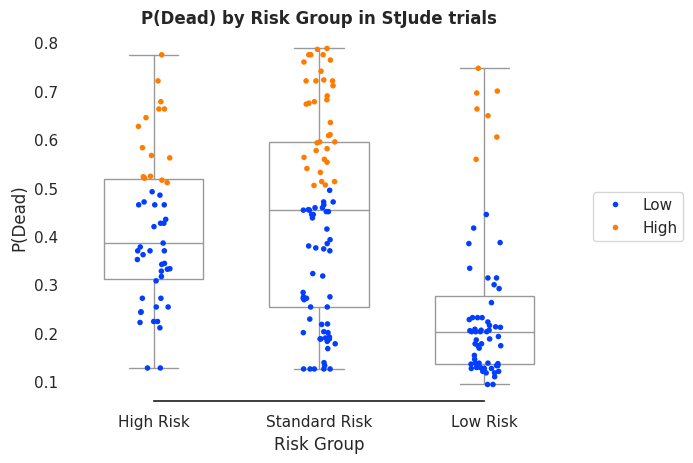

In [40]:
draw_boxplot(df=df_test,x='Risk Group', y='P(Dead)',
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='StJude trials', hue=model_name,
                save_plot=False, figsize=None)

draw_boxplot(df=df_test,x='MRD 1 Status', y='P(Dead)',
                order=['Positive','Negative'],
                trialname='StJude trials', hue=model_name,
                save_plot=False, figsize=None)

draw_boxplot(df=df_test,x='Primary Cytogenetic Code', y='P(Dead)',
                order='auto',
                trialname='StJude trials', hue=model_name,
                save_plot=False, figsize=None)

### Stacked Bar Plots

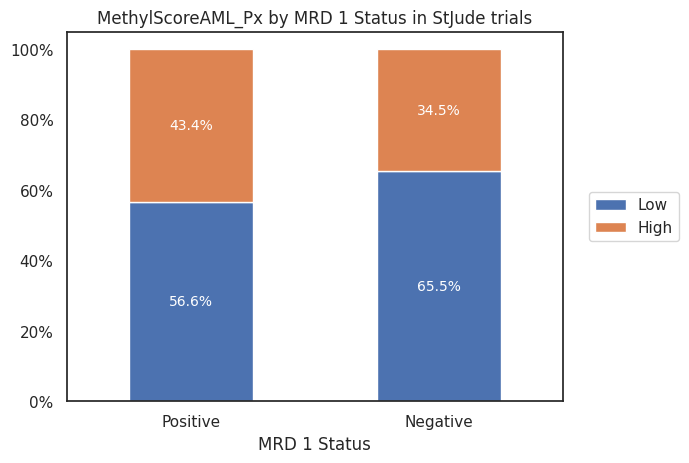

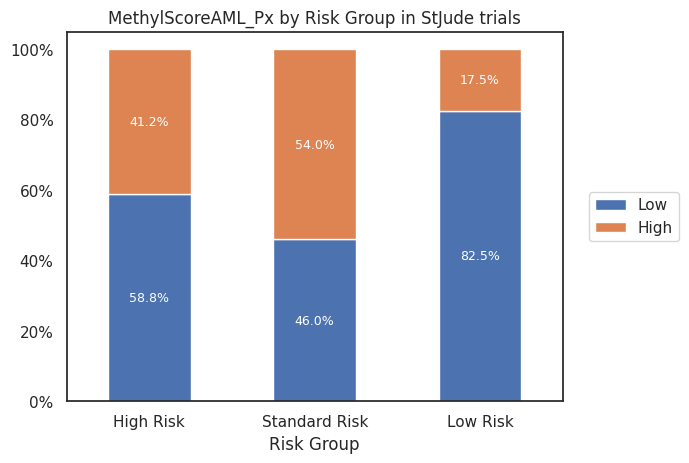

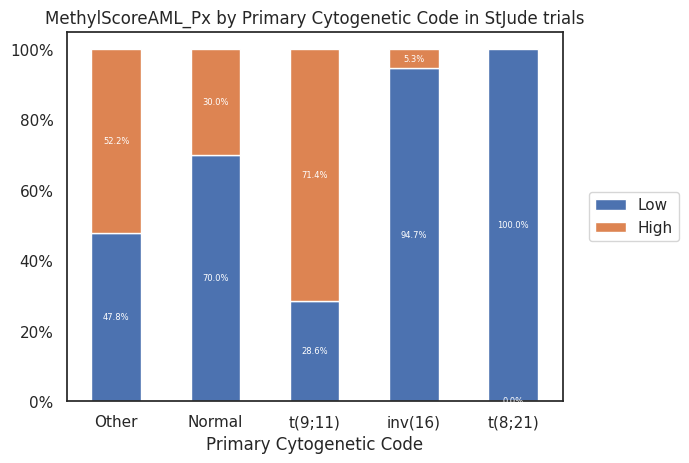

In [13]:
draw_stacked_barplot(df=validation_clinical_data,x='MRD 1 Status', y=score_name,
             order=['Positive','Negative'],
             trialname='StJude trials', hue=score_name + ' Categorical',
             save_plot=False, figsize=None)

draw_stacked_barplot(df=validation_clinical_data,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=9)

draw_stacked_barplot(df=validation_clinical_data,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=6)



### Patient Characteristics Table

#### Overall study population

In [14]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD','Treatment Arm']

validation_clinical_data['Age (years)'] = validation_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(validation_clinical_data, columns,
                        overall=False, missing=True,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']})

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_validation_cohort.csv')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','Validation Cohort'])

MethylScoreAML_Px,,Missing,Validation Cohort
n,,,201
"Age (years), mean (SD)",,2,8.8 (6.0)
"Age group (years), n (%)",≥10,2,95 (47.7)
,<10,,104 (52.3)
"Sex, n (%)",Female,0,87 (43.3)
,Male,,114 (56.7)
"Race or ethnic group, n (%)",White,2,143 (71.9)
,Black or African American,,32 (16.1)
,Asian,,1 (0.5)
,Native Hawaiian or other Pacific Islander,,2 (1.0)


#### Including both discovery and validation cohorts

In [15]:
# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

discovery_clinical_data['Age (years)'] = discovery_clinical_data['Age (years)'].astype(float)

px = discovery_clinical_data.loc[ewas_top_cpgs.index]

dx = discovery_clinical_data
# [~discovery_clinical_data['ELN 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
#                                        'Myeloid leukaemia associated with Down syndrome',
#                                        'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]
dx = dx[~dx['WHO 2022 Diagnosis'].isna()]

# Use only samples from df_index
dx = dx[dx.index.isin(pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=1).index)]

# join discovery clinical data with validation clinical data
all_cohorts = pd.concat([dx, px, validation_clinical_data],
                         axis=0, keys=['MethylScoreAML Dx Discovery','MethylScoreAML Px Discovery' ,'Validation'],
                         names=['cohort']).reset_index()


columns = ['Age group (years)','Sex', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)',
            'Risk Group','FLT3 ITD', 'Treatment Arm','Clinical Trial']

mytable_cog = TableOne(all_cohorts, columns,
                        overall=False, missing=False,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                                groupby='cohort')

mytable_cog.to_excel('../data/tableone_both_cohorts.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        # headers=[score_name,"",score_name,'Validation','p-value','Statistical Test']
)

,,MethylScoreAML Dx Discovery,MethylScoreAML Px Discovery,Validation
n,,2236,940,201
"Age group (years), n (%)",≥10,511 (47.1),458 (48.7),95 (47.7)
,<10,573 (52.9),482 (51.3),104 (52.3)
"Sex, n (%)",Female,696 (50.5),466 (49.6),87 (43.3)
,Male,683 (49.5),474 (50.4),114 (56.7)
"MRD 1 Status, n (%)",Positive,276 (29.3),258 (31.4),76 (40.2)
,Negative,666 (70.7),563 (68.6),113 (59.8)
"Leucocyte counts (10⁹/L), n (%)",≥30,568 (52.4),463 (49.3),88 (44.0)
,<30,516 (47.6),477 (50.7),112 (56.0)
"Risk Group, n (%)",High Risk,139 (11.7),128 (13.8),51 (25.4)


#### By MethylScore category

In [16]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD']

validation_clinical_data['Age (years)'] = validation_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(validation_clinical_data, columns,
                        overall=False, missing=True,
                        pval=True, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                        groupby=score_name + ' Categorical')

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_validation_methylscoreaml_px.csv')
mytable_cog.to_excel('../data/tableone_validation_methylscoreaml_px.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','High','Low','p-value','Statistical Test'])

MethylScoreAML_Px,,Missing,High,Low,p-value,Statistical Test
n,,,122,79,,
"Age (years), mean (SD)",,2,9.6 (5.5),7.5 (6.4),0.021,Two Sample T-test
"Age group (years), n (%)",≥10,2,65 (53.7),30 (38.5),0.050,Chi-squared
,<10,,56 (46.3),48 (61.5),,
"Sex, n (%)",Female,0,48 (39.3),39 (49.4),0.209,Chi-squared
,Male,,74 (60.7),40 (50.6),,
"Race or ethnic group, n (%)",White,2,87 (71.9),56 (71.8),0.721,Chi-squared (warning: expected count < 5)
,Black or African American,,21 (17.4),11 (14.1),,
,Asian,,,1 (1.3),,
,Native Hawaiian or other Pacific Islander,,1 (0.8),1 (1.3),,


## Watermark

In [17]:
%load_ext watermark

In [18]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,statannotations -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

pandas         : 2.0.2
seaborn        : 0.12.2
matplotlib     : 3.7.1
tableone       : 0.7.12
sklearn        : 1.2.2
lifelines      : 0.27.7
statannotations: 0.5.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

